Data sets used: https://drive.google.com/drive/folders/1rSVSzrvedNYeH_YZTLmgQJywQ4NOmLwf?usp=sharing

Where to find the latest version of this repo (we re-runned a model): https://github.com/hsanda/WorldDataLeagueStageTwo

## Please re download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request, json
from ipyleaflet import Map, Marker, basemaps, Polyline, LayersControl, AwesomeIcon, Circle, Rectangle, LayerGroup
from IPython.display import display
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.signal import butter, lfilter, freqz 
from scipy import signal
import matplotlib.dates as mdates

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
#note that the headers are completely wrong, we must merge latitude with longitude and entity_type with street.
#Then shift this two headers to the left
data_ent_df = pd.read_csv('data/data_entities.csv', encoding='latin1', index_col=False)
print('See that the last 4 headers make no sense')
data_ent_df.head()

See that the last 4 headers make no sense


,entity_id,name,latitude,longitude,entity_type,street,start_date,end_date
0,testsixsq,Rua dos Campees Europeus,41,162589760000003,-8,5851981169999991,TrafficFlowObserved,Rua dos Campees Europeus
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,R. Fernandes Toms - 24 de Agosto,41,148405920000002,-8,5990938559999996,TrafficFlowObserved,Rua de Fernandes Toms
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,R. Cames - N-S,41,154959804999997,-8,6100910160000002,TrafficFlowObserved,Rua de Cames
3,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,Av. Boavista - Casa da Msica - E-O,41,158700713000002,-8,6335461250000005,TrafficFlowObserved,Avenida da Boavista
4,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,Via Panormica - Faixa BUS,41,151096148000001,-8,6338182700000008,TrafficFlowObserved,Rua de Entre Campos


In [3]:
# here the changes to column names get made
longitude = []
latitude = []
for index, row in data_ent_df.iterrows():
    lat = float(("%s.%s"% (str(row['latitude']), str(row['longitude']))))
    long = float(("%s.%s"% (str(row['entity_type']), str(row['street']))))
    longitude.append(long)
    latitude.append(lat)
data_ent_df = data_ent_df.drop(['latitude', 'longitude', 'entity_type', 'street'], axis=1)
data_ent_df['latitude'] = latitude
data_ent_df['longitude'] = longitude
data_ent_df = data_ent_df.rename(columns={'start_date':'entity_type', 'end_date':'street'})
data_ent_df['pos'] = list(zip(data_ent_df.latitude, data_ent_df.longitude))
data_ent_df.head()

,entity_id,name,entity_type,street,latitude,longitude,pos
0,testsixsq,Rua dos Campees Europeus,TrafficFlowObserved,Rua dos Campees Europeus,41.162590,-8.585198,"(41.16258976, -8.585198117)"
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,R. Fernandes Toms - 24 de Agosto,TrafficFlowObserved,Rua de Fernandes Toms,41.148406,-8.599094,"(41.14840592, -8.599093856)"
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,R. Cames - N-S,TrafficFlowObserved,Rua de Cames,41.154960,-8.610091,"(41.154959805, -8.610091016)"
3,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,Av. Boavista - Casa da Msica - E-O,TrafficFlowObserved,Avenida da Boavista,41.158701,-8.633546,"(41.158700713, -8.633546125)"
4,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,Via Panormica - Faixa BUS,TrafficFlowObserved,Rua de Entre Campos,41.151096,-8.633818,"(41.151096148, -8.63381827)"


In [4]:
# more insigts
print('The unique sensor types are + some further insights :')
data_ent_df.groupby("entity_type").count() 
## !! however we will find out that 2 rows are wrongly classified as a specific entity type

The unique sensor types are + some further insights :


,entity_id,name,street,latitude,longitude,pos
entity_type,,,,,,
AirQualityObserved,10,10,0,10,10,10
NoiseLevelObserved,18,18,0,18,18,18
TrafficFlowObserved,130,130,128,130,130,130
WeatherObserved,28,28,0,28,28,28


In [5]:
#check the location of the sensors  

dict_icon ={"TrafficFlowObserved":"car","NoiseLevelObserved":"volume-up",
           "AirQualityObserved":"heart-o","WeatherObserved":"tint"}
dict_col ={"TrafficFlowObserved":"black","NoiseLevelObserved":"gray",
           "AirQualityObserved":"orange","WeatherObserved":"blue"}

city_center_porto=(41.14961, -8.61099)
m = Map(center=city_center_porto, zoom=8) ## bew
m2 = Map(center=city_center_porto, zoom=12) ## bew
for entity in data_ent_df.entity_type.unique():
    icon_temp = AwesomeIcon(name=dict_icon.get(entity),marker_color=dict_col.get(entity))
    df_temp = data_ent_df[data_ent_df.entity_type==entity]
    for loc in df_temp.pos:
        m.add_layer(Marker(icon=icon_temp,location=loc, draggable=True))
        m2.add_layer(Marker(icon=icon_temp,location=loc, draggable=True))
display(m)
print('Zoom in Porto sensors')
display(m2)

Map(center=[41.14961, -8.61099], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Zoom in Porto sensors


Map(center=[41.14961, -8.61099], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

# Load data from the sensors

In [6]:
#load original datasets of specific sensor type + year 
traffic_df_2018 = pd.read_csv('data/traffic_flow_2018.csv', encoding='latin1')
traffic_df_2019 = pd.read_csv('data/traffic_flow_2019.csv', encoding='latin1')
air_df_2018     = pd.read_csv('data/air_quality_2018.csv', encoding='latin1')
air_df_2019     = pd.read_csv('data/air_quality_2019.csv', encoding='latin1')
noise_df_2018   = pd.read_csv('data/noise_level_2018.csv', encoding='latin1')
noise_df_2019   = pd.read_csv('data/noise_level_2019.csv', encoding='latin1')
weather_df_2018 = pd.read_csv('data/weather_observed_2018.csv', encoding='latin1') 
weather_df_2019 = pd.read_csv('data/weather_observed_2019.csv', encoding='latin1')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Check for anomalies in the time data

In [7]:
import re

def dates_format_check(df,cols=["dateobservedfrom","dateobservedto"]):
### this is not precise but roughly checks for some mistakes 
    for c in cols:
        print("checking:",c)
        col=df[c]
        temp2 = col.apply(lambda x: len(re.compile(r'^\d\d\d\d-').findall(x))==1) 
        temp = col.map(len)!=19
        print("are there any times that do not fit the standard format?", temp.any()+temp2.all())

        ## or starts with date and has lots of microseconds?
        temp3 =  col[temp].apply(lambda x: len(re.compile(r':\d\d\d\d$').findall(x))==0) 
        print("If true are they maybe due to the display of many microseconds?", temp2.all() + temp3.all())
print('Checking for 2018 traffic data')
dates_format_check(traffic_df_2018,["dateobservedfrom","dateobservedto"]) # this takes long to run 1 min
print('Checking for 2019 traffic data')
dates_format_check(traffic_df_2019,["dateobservedfrom","dateobservedto"])

Checking for 2018 traffic data
checking: dateobservedfrom
are there any times that do not fit the standard format? True
If true are they maybe due to the display of many microseconds? True
checking: dateobservedto
are there any times that do not fit the standard format? True
If true are they maybe due to the display of many microseconds? True
Checking for 2019 traffic data
checking: dateobservedfrom
are there any times that do not fit the standard format? True
If true are they maybe due to the display of many microseconds? True
checking: dateobservedto
are there any times that do not fit the standard format? True
If true are they maybe due to the display of many microseconds? True


Break down the date&time columns into year, month, week, day, hour, minute, second

In [8]:
#takes around 15 minutes to run
from datetime import datetime

def convert_time2(df,col):
    df[col]=df[col].apply(lambda x: x[:19]) 
    df[col]=df[col].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S")) 
    time_elements = ["year","month","day","hour","minute","second","dayofweek"]
    for el in time_elements:
        df[col+"_"+el]=eval("df[col].dt."+el)
    return df

traffic_df_2018 = convert_time2(traffic_df_2018,"dateobservedfrom")
traffic_df_2018 = convert_time2(traffic_df_2018,"dateobservedto")
traffic_df_2019 = convert_time2(traffic_df_2019,"dateobservedfrom")
traffic_df_2019 = convert_time2(traffic_df_2019,"dateobservedto")
weather_df_2018= convert_time2(weather_df_2018,"dateobserved")
weather_df_2019= convert_time2(weather_df_2019,"dateobserved")
air_df_2018=convert_time2(air_df_2018,"dateobserved")
air_df_2019=convert_time2(air_df_2019,"dateobserved")
noise_df_2018=convert_time2(noise_df_2018,"dateobserved")
noise_df_2019=convert_time2(noise_df_2019,"dateobserved")
traffic_df_2018["observed_time_delta"] =   traffic_df_2018.dateobservedto - traffic_df_2018.dateobservedfrom
traffic_df_2019["observed_time_delta"] =   traffic_df_2019.dateobservedto - traffic_df_2019.dateobservedfrom 

Run only if you need to save the files

In [15]:
noise_df_2018.to_csv("data/noise_2018_new.csv", index = True)
noise_df_2019.to_csv("data/noise_2019_new.csv", index = True)
traffic_df_2018.to_csv('data/traffic_2018_updated.csv', index = True)
traffic_df_2019.to_csv('data/traffic_2019_updated.csv', index = True)
weather_df_2018.to_csv('data/weather_2018_new.csv', index = True)
weather_df_2019.to_csv('data/weather_2019_new.csv', index = True)
air_df_2018.to_csv("data/air_2018_new.csv", index = True)
air_df_2019.to_csv("data/air_2019_new.csv", index = True)

# Exploratory Data Analysis and Pre-processing

In [9]:
from geopy.distance import lonlat, distance
import datetime
import seaborn as sns

In [10]:
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]
    
def split_up_cols(col):
    col=col.apply(lambda x: x.replace("[","")).apply(lambda x: x.replace("]",""))
    col = col.apply(lambda x: x.split(","))
    col=col.apply(lambda x: [float(elem.replace("(","").replace(")","")) for elem in x])
    col = col.apply(lambda x:list(zip(x[0::2], x[1::2])))
    return col

For the sake of brevity, from this point on we will focus on a specific traffic sensor, CT4Z7.
Note that, all the below can be simply modified for the other traffic sensors by changing the name. 

In [11]:
# CT4Z7 traffic 
def prep_CT4Z7_df(df,select_col_wo_to=True):
    # select only CT4Z7
    df_temp_CT4Z7=df[df.entity_id=="urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT4Z7"] 
    # put dates + time deltas in easy to handle format
    df_temp_CT4Z7["dateobservedfrom"]=pd.to_datetime(pd.Series(df_temp_CT4Z7["dateobservedfrom"]),format="%Y-%m-%d %H:%M:%S")
    df_temp_CT4Z7["observed_time_delta"] = pd.to_timedelta(df_temp_CT4Z7["observed_time_delta"])
    df_temp_CT4Z7["observed_time_delta"]=abs(df_temp_CT4Z7["observed_time_delta"].dt.total_seconds()/60)
    ####### possibility: check out whenever observed time delta is neg. whether the measures seems to be wrong
    # sort to make life easier 
    df_temp_CT4Z7=df_temp_CT4Z7.sort_values(by=["dateobservedfrom"])
    
    #select only relevant columns (2 options one w/ observed_time_delta)
    if select_col_wo_to:
        df_temp_CT4Z7 = df_temp_CT4Z7[['dateobservedfrom',"intensity",'dateobservedfrom_year', 'dateobservedfrom_month',
               'dateobservedfrom_day', 'dateobservedfrom_hour',
               'dateobservedfrom_minute', 'dateobservedfrom_second',
               'dateobservedfrom_dayofweek']]
    else:
        df_temp_CT4Z7 = df_temp_CT4Z7[['dateobservedfrom',"dateobservedto","intensity",'dateobservedfrom_year', 'dateobservedfrom_month',
               'dateobservedfrom_day', 'dateobservedfrom_hour',
               'dateobservedfrom_minute', 'dateobservedfrom_second',
               'dateobservedfrom_dayofweek',"observed_time_delta"]]
     
    return df_temp_CT4Z7

def get_surrounding_measures(df,id_center,nb_hours_bef_n_after=3):
    year_rel=df.loc[id_center].dateobservedfrom_year
    month_rel=df.loc[id_center].dateobservedfrom_month
    day_rel = df.loc[id_center].dateobservedfrom_day
    hour_rel=df.loc[id_center].dateobservedfrom_hour
    df_rel = df[df.dateobservedfrom_year==year_rel]
    df_rel = df_rel[df_rel.dateobservedfrom_month==month_rel]
    df_rel = df_rel[df_rel.dateobservedfrom_day==day_rel]
    df_rel = df_rel[df_rel.dateobservedfrom_hour<=hour_rel+nb_hours_bef_n_after]
    df_rel = df_rel[df_rel.dateobservedfrom_hour>=hour_rel-nb_hours_bef_n_after]
    return df_rel

In [12]:
traffic_df_2018_updated = traffic_df_2018
traffic_df_2019_updated = traffic_df_2019
#traffic_df_2018_updated = pd.read_csv('data/traffic_flow_2018_updated.csv', encoding='latin1')
df_CT4Z7_2018=prep_CT4Z7_df(traffic_df_2018_updated,False)
#traffic_df_2019_updated = pd.read_csv('data/traffic_flow_2019_updated.csv', encoding='latin1')
df_CT4Z7_2019=prep_CT4Z7_df(traffic_df_2019_updated,False)

Note that a few traffic measurements did not take 5 minutes.

In [13]:
print(df_CT4Z7_2018.observed_time_delta.unique())
print(df_CT4Z7_2019.observed_time_delta.unique())
df_CT4Z7_2019[df_CT4Z7_2019.observed_time_delta!=5.0]

[5.]
[  5.           3.23333333   4.76666667   3.26666667   0.
 475.        ]


,dateobservedfrom,dateobservedto,intensity,dateobservedfrom_year,dateobservedfrom_month,dateobservedfrom_day,dateobservedfrom_hour,dateobservedfrom_minute,dateobservedfrom_second,dateobservedfrom_dayofweek,observed_time_delta
6888111,2019-03-06 21:18:14,2019-03-06 21:15:00,59,2019,3,6,21,18,14,2,3.233333
7909401,2019-04-14 10:40:14,2019-04-14 10:45:00,71,2019,4,14,10,40,14,6,4.766667
3550852,2019-04-28 03:53:16,2019-04-28 03:50:00,12,2019,4,28,3,53,16,6,3.266667
8583808,2019-11-17 07:00:00,2019-11-17 07:00:00,18,2019,11,17,7,0,0,6,0.000000
6619001,2019-12-01 07:55:00,2019-12-01 00:00:00,20,2019,12,1,7,55,0,6,475.000000


Only 5 rows of the traffic data from 2019 have delta != 5mins. This will get drop

<AxesSubplot:>

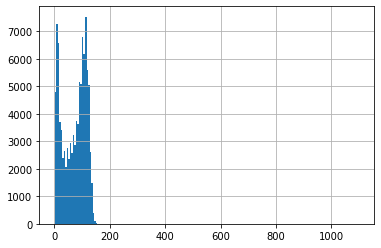

In [14]:
df_CT4Z7_2019_only5min =df_CT4Z7_2019[df_CT4Z7_2019.observed_time_delta==5.0]
df_CT4Z7_2019_only5min.intensity.hist(bins=200)

Next, we merge the 2018 and 2019 dataframes

<AxesSubplot:>

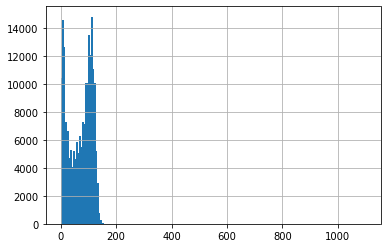

In [15]:
assert pd.Series(df_CT4Z7_2018.columns==df_CT4Z7_2019.columns).all()
traffic_CT4Z7_2018_19 = df_CT4Z7_2018.append(df_CT4Z7_2019)
assert len(traffic_CT4Z7_2018_19)==len(df_CT4Z7_2019)+len(df_CT4Z7_2018)
traffic_CT4Z7_2018_19.intensity.hist(bins=200) # most is  <200

Next, we call the noise, weather and air data from the nearby sensors

In [16]:
#### these sensor information are within 300 m distance of the row 
#5b87a6dc0dde591949bb8b5d weather 
# 5b8672700dde591949ba5005 noise
# air 5b72dbfa06599b05e9a74f27

def select_data_for_specific_sensor(df,type_of_sensor):
    if type_of_sensor=="weather":
        df["entity_id"]= df["entity_id"].apply(
            lambda x: x.replace("urn:ngsi-ld:WeatherObserved:porto:weather:ubiwhere:","").replace(
                "urn:ngsi-ld:WeatherObserved:porto:weahter:ubiwhere:","").replace(
            'urn:ngsi-ld:WeatherObserved:porto:weather:communityStations:','').replace(
            'urn:ngsi-ld:AirQualityObserved:porto:weather:ubiwhere:',''))

        df=df[df.entity_id=="5b87a6dc0dde591949bb8b5d"]
        print("len weather:",len(df))
        df = df.iloc[:,:-3]
        del df["entity_id"]
        del df["entity_type"]
        df.dropna(axis=1, how='all',inplace=True)
        df["dateobserved"]=pd.to_datetime(pd.Series(df["dateobserved"]),format="%Y-%m-%d %H:%M:%S")
        df = df.sort_values(by=["dateobserved"])
        return df
        
    elif type_of_sensor=="noise":

        df["entity_id"]= df["entity_id"].apply(lambda x: x.replace(
            "urn:ngsi-ld:NoiseLevelObserved:porto:noise:ubiwhere:",""))
        df=df[df.entity_id=="5b8672700dde591949ba5005"]
        print("len noise:",len(df))
        df = df.iloc[:,:-5]
        del df["entity_id"]
        del df["entity_type"]
        df["dateobserved"]=pd.to_datetime(pd.Series(df["dateobserved"]),format="%Y-%m-%d %H:%M:%S")
        df = df.sort_values(by=["dateobserved"])
        return df
        
        
    elif type_of_sensor=="air":

        df["entity_id"]= df["entity_id"].apply(lambda x: x.replace(
            "urn:ngsi-ld:AirQualityObserved:porto:environment:ubiwhere:",""))
        df=df[df.entity_id=="5b72dbfa06599b05e9a74f27"]
        print("len air:",len(df))
        df = df.iloc[:,:-5]
        del df["entity_id"]
        del df["entity_type"]
        df["dateobserved"]=pd.to_datetime(pd.Series(df["dateobserved"]),format="%Y-%m-%d %H:%M:%S")
        df = df.sort_values(by=["dateobserved"])
        return df 
    
    else: print("pls enter correct type_of_sensor")
        
#get the data
air_2018_19_CT4Z7 = select_data_for_specific_sensor(air_df_2018,"air").append(
                select_data_for_specific_sensor(air_df_2019,"air"))
noise_2018_19_CT4Z7 = select_data_for_specific_sensor(noise_df_2018,"noise").append(
                select_data_for_specific_sensor(noise_df_2019,"noise"))
weather_2018_19_CT4Z7 =select_data_for_specific_sensor(weather_df_2018,"weather").append(
                select_data_for_specific_sensor(weather_df_2019,"weather"))

len air: 7263
len air: 100596
len noise: 7217
len noise: 101901
len weather: 7689
len weather: 102599


Check if the sensor measurements stretch over the same time period.
They start at different times. It looks like the air, weather and noise sensors were all installed on 2018-12-06 12:23:06. This will limit our data for the models.

In [17]:
print("traffic min max time",
      traffic_CT4Z7_2018_19.dateobservedfrom.min(),traffic_CT4Z7_2018_19.dateobservedfrom.max())

print("-------")
print("air min max",air_2018_19_CT4Z7.dateobserved.min(),air_2018_19_CT4Z7.dateobserved.max())
print("weather min max",weather_2018_19_CT4Z7.dateobserved.min(),weather_2018_19_CT4Z7.dateobserved.max())
print("noise min max",noise_2018_19_CT4Z7.dateobserved.min(),noise_2018_19_CT4Z7.dateobserved.max())

# 2018-12-06 12:25:00 select the traffic data 
lower_date_limit = noise_2018_19_CT4Z7.dateobserved.min()
df_traffic = traffic_CT4Z7_2018_19[traffic_CT4Z7_2018_19.dateobservedfrom>lower_date_limit]

traffic min max time 2017-12-31 00:00:00 2019-12-31 23:50:00
-------
air min max 2018-12-06 12:23:06 2019-12-31 17:21:42
weather min max 2018-12-06 12:22:58 2019-12-31 23:58:41
noise min max 2018-12-06 12:23:21 2019-12-31 23:55:37


Below we carry out further analysis of the data, which will help us to engineer features for the models.

### Periodicity of traffic

In [18]:
# analyze time deltas between measurements 
def time_deltas(col):
    list_deltas = []
    temp_last=0
    for v in col:
        if v==col.iloc[0]:
            temp_last = v
            continue # skip first one
        list_deltas.append(v-temp_last)  
        temp_last = v
    return abs(pd.Series(list_deltas).dt.total_seconds()/60)

# aggregate on per-hour basis + using the mean
def round_2_hours(df,col): ## different  for traffic!! 
    df[col]=pd.to_datetime(df[col],format="%Y-%m-%d %H:%M:%S") # first put col into date format 
    df[col]=df[col].apply(lambda x: x.round(freq="H"))
    result = df.groupby(col).mean().reset_index()
    return result

# combine all sensor data with left join on traffic data
def merge_all_sensors(df,arr):
    for a in arr:
        df=df.merge(a,how="left",on="dateobserved")
    return df


Use the mean of the hours for the sensors and put all sensor data in one df 

In [19]:
weather_CT4Z7_by_h = round_2_hours(weather_2018_19_CT4Z7,"dateobserved")
air_CT4Z7_by_h     = round_2_hours(air_2018_19_CT4Z7,"dateobserved")
noise_CT4Z7_by_h   = round_2_hours(noise_2018_19_CT4Z7,"dateobserved")

traffic_CT4Z7_by_h = round_2_hours(df_traffic,"dateobservedfrom")
traffic_CT4Z7_by_h.rename(columns={'dateobservedfrom':"dateobserved"},inplace=True)

CT4Z7_by_h_all     = merge_all_sensors(traffic_CT4Z7_by_h,[weather_CT4Z7_by_h,air_CT4Z7_by_h,noise_CT4Z7_by_h])
CT4Z7_by_h_all.head()

,dateobserved,intensity,dateobservedfrom_year,dateobservedfrom_month,dateobservedfrom_day,dateobservedfrom_hour,dateobservedfrom_minute,dateobservedfrom_second,dateobservedfrom_dayofweek,observed_time_delta,...,pm10,latitude_x,longitude_x,dateobserved_year_y,dateobserved_month_y,laeq,latitude_y,longitude_y,dateobserved_year,dateobserved_month
0,2018-12-06 12:00:00,115.500000,2018.0,12.0,6.0,12.000000,27.500000,0.0,3.0,5.0,...,44.250000,41.162596,-8.590796,2018.0,12.0,71.700001,41.162596,-8.590796,2018.0,12.0
1,2018-12-06 13:00:00,124.272727,2018.0,12.0,6.0,12.545455,27.272727,0.0,3.0,5.0,...,66.350000,41.162596,-8.590796,2018.0,12.0,71.766667,41.162596,-8.590796,2018.0,12.0
2,2018-12-06 14:00:00,118.461538,2018.0,12.0,6.0,13.538462,27.692308,0.0,3.0,5.0,...,100.183334,41.162596,-8.590796,2018.0,12.0,71.116666,41.162596,-8.590796,2018.0,12.0
3,2018-12-06 15:00:00,118.909091,2018.0,12.0,6.0,14.545455,27.272727,0.0,3.0,5.0,...,57.383333,41.162596,-8.590796,2018.0,12.0,71.075000,41.162596,-8.590796,2018.0,12.0
4,2018-12-06 16:00:00,113.307692,2018.0,12.0,6.0,15.538462,27.692308,0.0,3.0,5.0,...,74.900000,41.162596,-8.590796,2018.0,12.0,71.870501,41.162596,-8.590796,2018.0,12.0


Due to missing data starting from may 2019, we decide to focus on the months prior to this date.

In [20]:
CT4Z7_by_h_cut_may2019 = CT4Z7_by_h_all.iloc[:4100]

We assume to have periodicity within our traffic intensity data. To verify that we plot the power spectral density. As we only focus on traffic intensity data we don´t have to limit our CT4Z7-data as we did previously but can take traffic_CT4Z7_2018_19 for the analysis. However, for this analysis we should check the data for outliers and gaps.

<IPython.core.display.Javascript object>


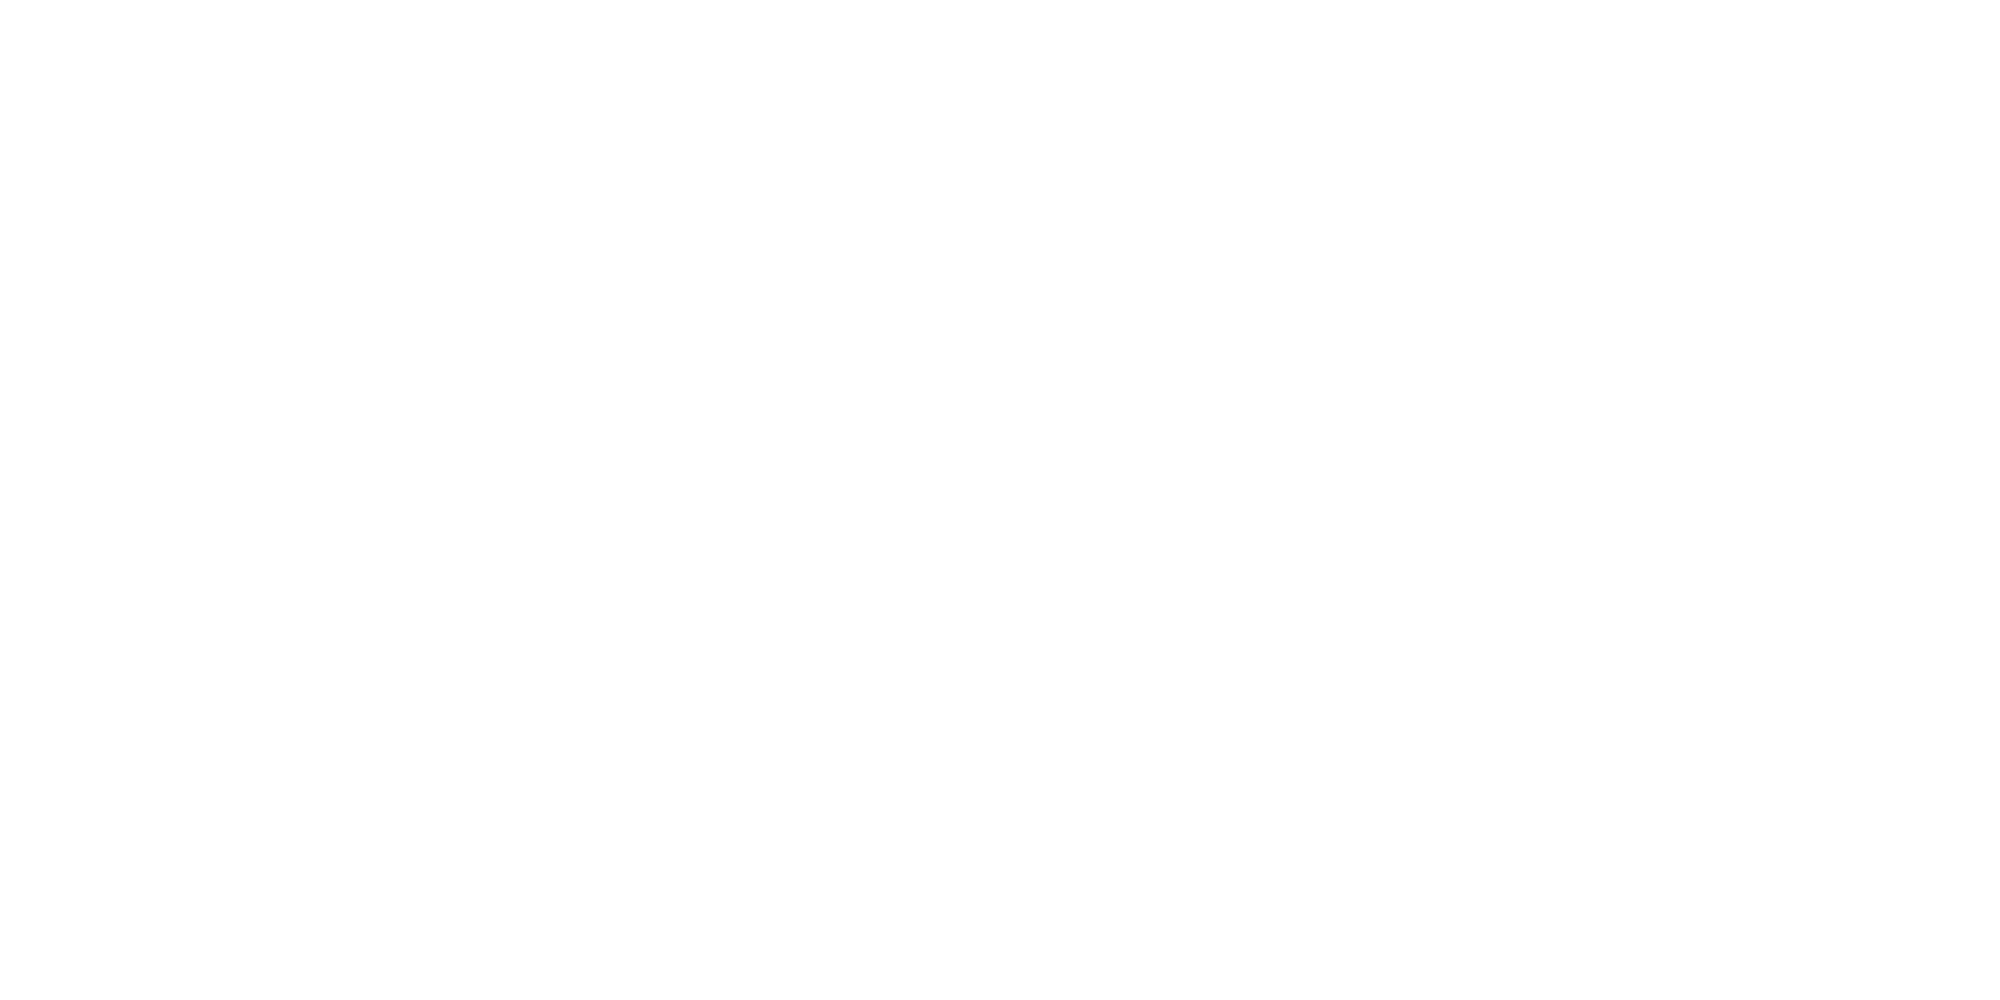

In [21]:
# outliers or gaps in the data?
%matplotlib notebook
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.lineplot(data=traffic_CT4Z7_2018_19 ,x="dateobservedfrom",y="intensity")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
plt.xticks(rotation=45)
plt.tight_layout()


As outliers and gaps are in the data we cut the data in early July 2018  and replace the two outliers. For that the outliers need to be understood first and than imputed

<IPython.core.display.Javascript object>


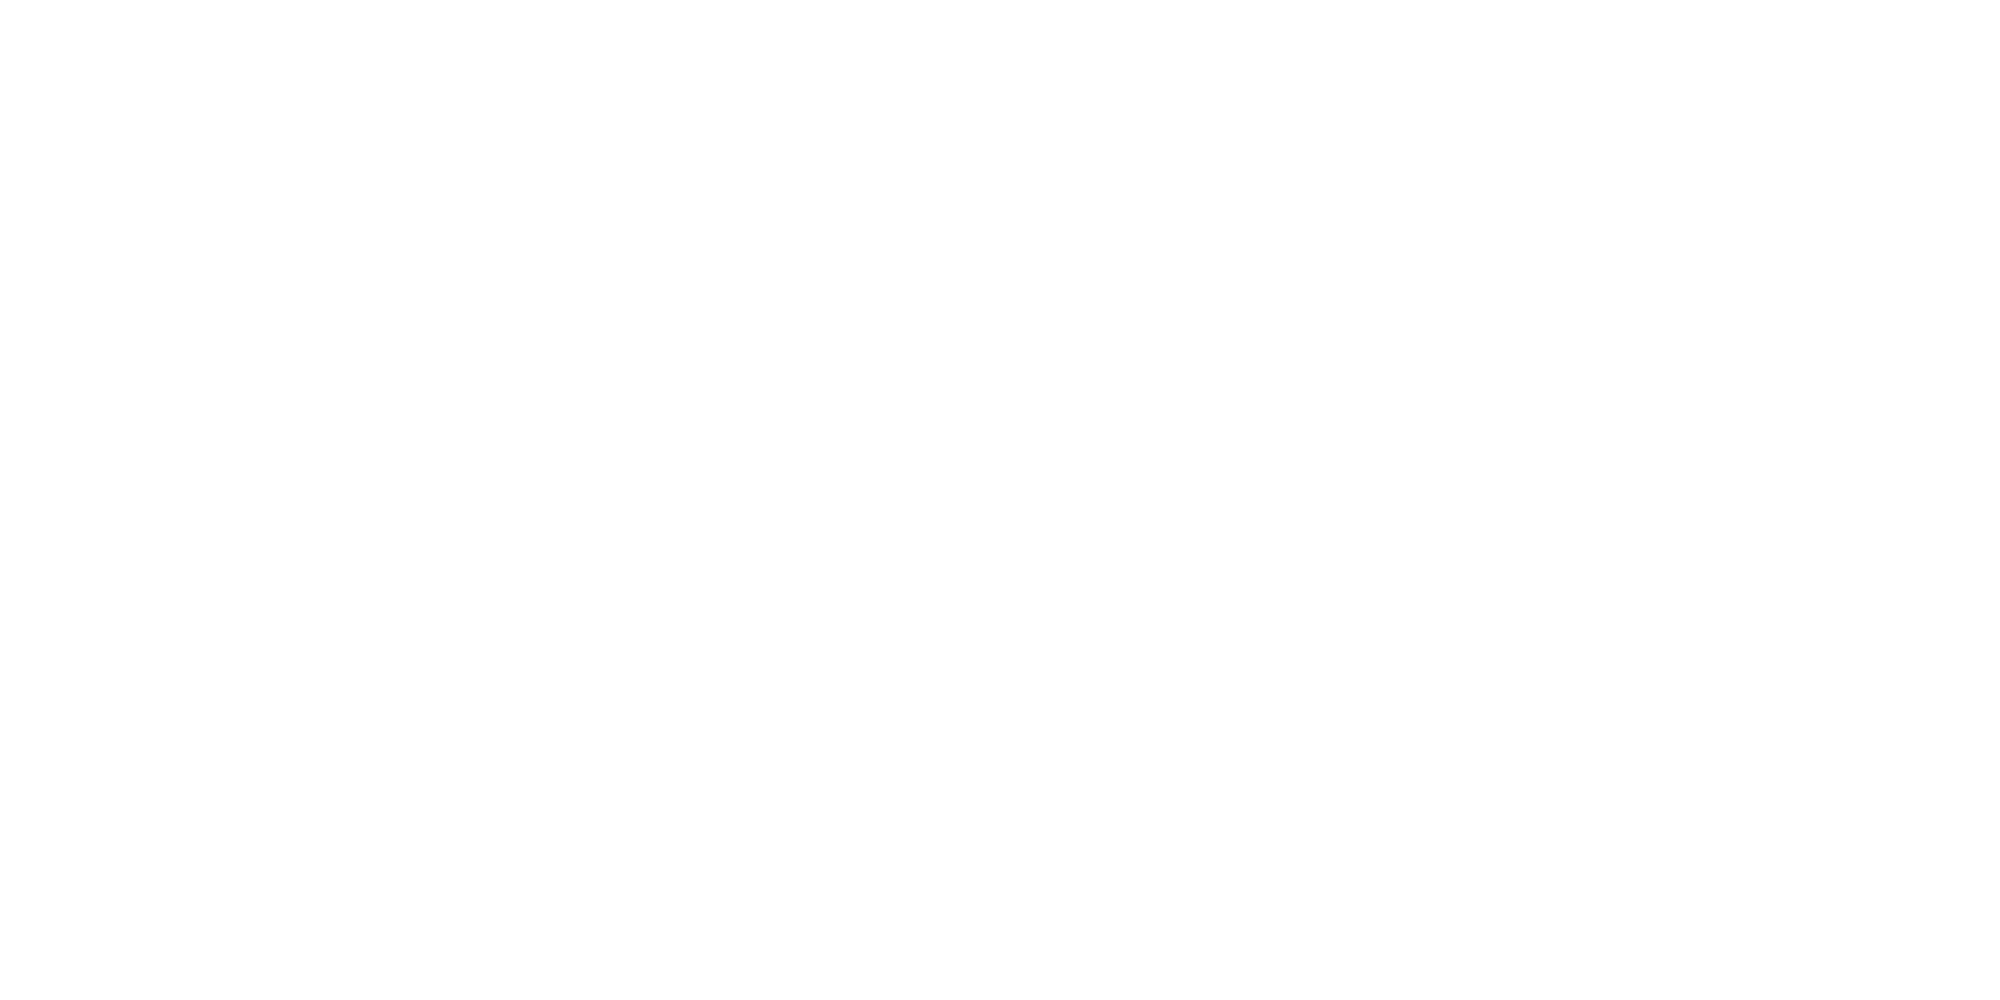

In [22]:
df_period_ana = traffic_CT4Z7_2018_19[traffic_CT4Z7_2018_19.dateobservedfrom>np.datetime64('2018-07-05')]

df_period_ana_temp = df_period_ana[df_period_ana.intensity>200]

#looking at this temporary dataframe we see that the first outlier is causes by a single row whereas 
#the others ones build a consecutive sequence


# impute first outlier
value_to_impute_1 = df_period_ana[df_period_ana.dateobservedfrom>np.datetime64('2019-06-28 22:05:00')].iloc[[
    0,2],2].mean()
df_period_ana.loc[5067703,"intensity"]=value_to_impute_1


# understand second outliers 
df_period_ana_temp=df_period_ana[df_period_ana.dateobservedfrom>np.datetime64("2019-11-27 10:00:00")].iloc[:2000,:]

original_data =False ## change here to True to see original Data

if original_data==False:
# put the positive outliers into categories of what they vary from the surrounding values and deduce
# estimate the actual value by subtracting the difference (between meassured value and surrounding values)
    df_period_ana_temp["intensity"]=df_period_ana_temp.intensity.apply(lambda x: x-1000 if x>1000 else x)
    df_period_ana_temp["intensity"]=df_period_ana_temp.intensity.apply(lambda x: x-750 if x>800 else x)
    df_period_ana_temp["intensity"]=df_period_ana_temp.intensity.apply(lambda x: x-600 if x>700 else x)
    df_period_ana_temp["intensity"]=df_period_ana_temp.intensity.apply(lambda x: x-500 if x>500 else x)
    df_period_ana_temp["intensity"]=df_period_ana_temp.intensity.apply(lambda x: x-350 if x>400 else x)
    df_period_ana_temp["intensity"]=df_period_ana_temp.intensity.apply(lambda x: x-250 if x>250 else x)
    df_period_ana_temp["intensity"]=df_period_ana_temp.intensity.apply(lambda x: x-200 if x>250 else x)
    df_period_ana_temp["intensity"]=df_period_ana_temp.intensity.apply(lambda x: x-150 if x>200 else x)

%matplotlib notebook
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.lineplot(data=df_period_ana_temp ,x="dateobservedfrom",y="intensity")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
plt.xticks(rotation=45)
plt.tight_layout()

# impute second outlier
df_period_ana.loc[df_period_ana_temp.index.to_list(),"intensity"]=df_period_ana_temp["intensity"]





The modified df_period_ana serves now as input for the peridociity analysis

<IPython.core.display.Javascript object>


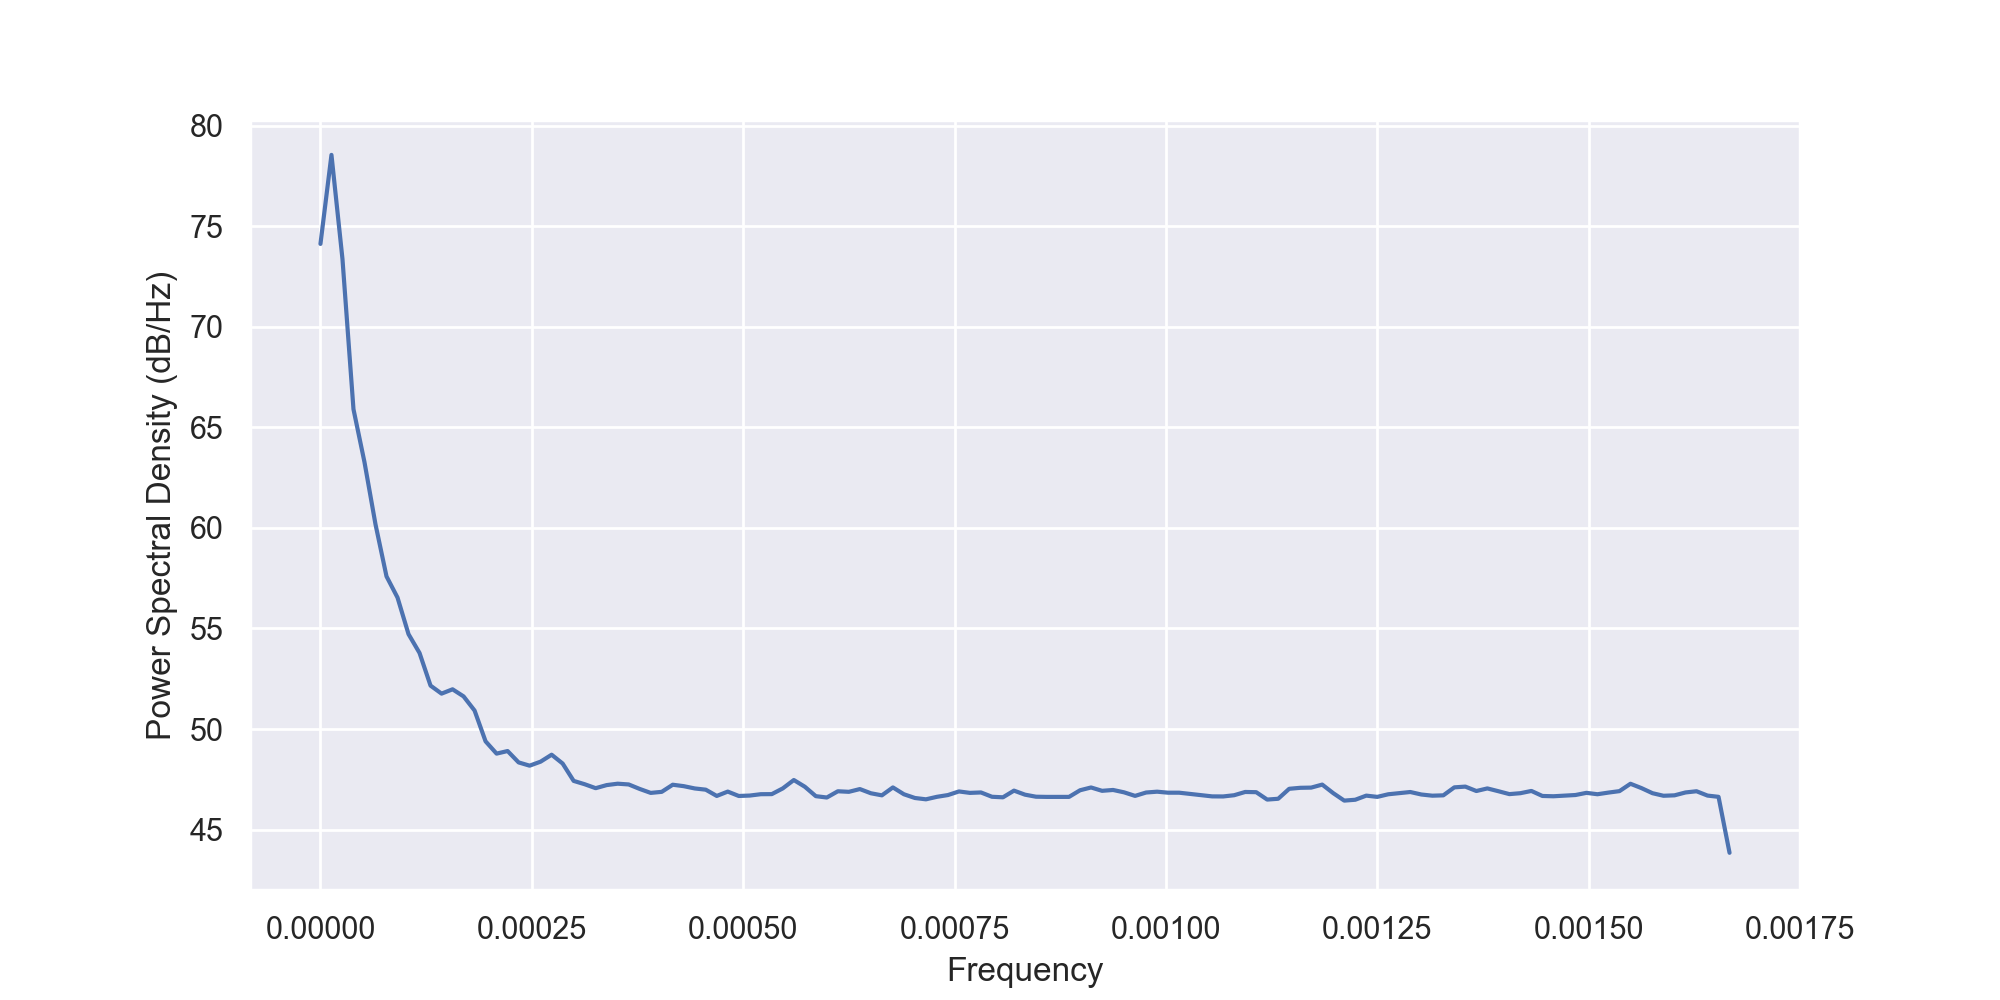

In [23]:
%matplotlib notebook
plt.psd(df_period_ana.intensity-df_period_ana.intensity.mean(),Fs=1/(60*5))
plt.yscale("linear")

As there is an outstanding strong periodicities recognizable in the plot, we want to find out the respective frequency.

In [24]:
# now calculate the peaks 
result_welch = signal.welch(df_period_ana.intensity-df_period_ana.intensity.mean(),fs= 1/(60*5))
df_welch=pd.DataFrame(data=result_welch[1],index=result_welch[0],columns=["Power_spectral_density"])

df_welch=df_welch.sort_values(by=["Power_spectral_density"])

# get frequency for strongers periodicity
max_frequ=df_welch[df_welch.Power_spectral_density ==df_welch.Power_spectral_density.max()].index[0]
print("strongest periodicity recognized every",1/max_frequ,"seconds") 
print("strongest periodicity recognized every",1/max_frequ/60/60,"hours")
print("strongest periodicity recognized every",1/max_frequ/60/60/24,"days")

strongest periodicity recognized every 76800.0 seconds
strongest periodicity recognized every 21.333333333333332 hours
strongest periodicity recognized every 0.8888888888888888 days


In front of the background, that the welch assumes not two different connected periodicities (like daytime and nighttime), the stronges periodicity recognized every 21.33 hours allows us to deduce that the strongest periodicity is caused by a day-cycle. 


# Models 

## ARIMA

We will start by building a model using ARIMA. For this model, no features are used, only the past traffic data.

In [65]:
from matplotlib import pyplot, figure
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sktime.forecasting.model_selection import temporal_train_test_split
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

                      intensity
dateobserved                   
2018-12-06 12:00:00  115.500000
2018-12-06 13:00:00  124.272727
2018-12-06 14:00:00  118.461538
2018-12-06 15:00:00  118.909091
2018-12-06 16:00:00  113.307692
(4100, 1)


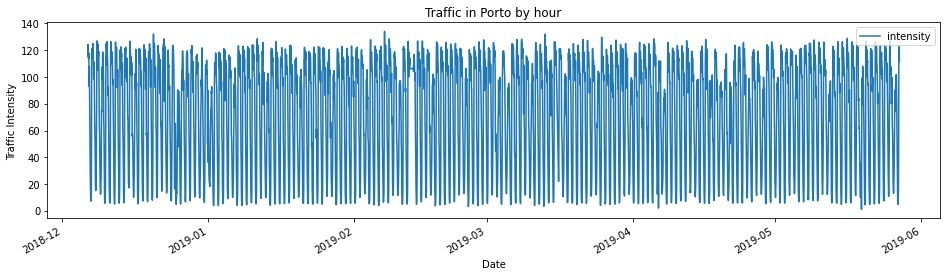

In [41]:
temp_df = CT4Z7_by_h_cut_may2019[['dateobserved', 'intensity']] #for JO code, intensity here is the mean, only for one sensor
temp_df = temp_df.fillna(0)
temp_df = temp_df.sort_values(by=['dateobserved'])

temp_df = temp_df.set_index('dateobserved')
print(temp_df.head())
print(temp_df.shape)

temp_df.plot(kind = 'line', y = 'intensity', title = 'Traffic in Porto by hour', xlabel ='Date', ylabel='Traffic Intensity', figsize=(16,4))
plt.show()

<class 'pandas.core.frame.DataFrame'>
Confirm that the Dataframe was transformed to a Series:
<class 'pandas.core.series.Series'>
Confirm that the index is now a period index:
<class 'pandas.core.indexes.period.PeriodIndex'>
The final dataframe looks as follows
dateobserved
2018-12-06 12:00    115.500000
2018-12-06 13:00    124.272727
2018-12-06 14:00    118.461538
2018-12-06 15:00    118.909091
2018-12-06 16:00    113.307692
Freq: H, Name: intensity, dtype: float64


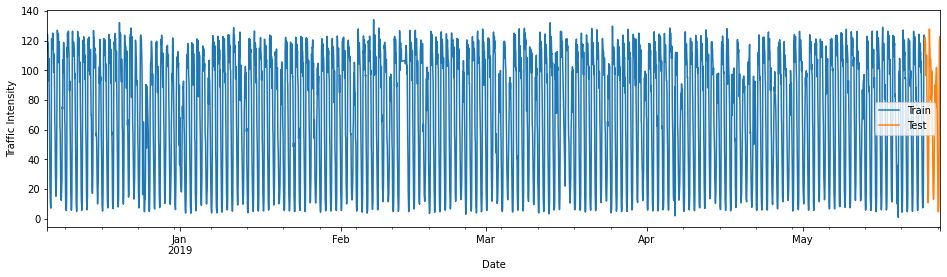

In [54]:
df_test = temp_df
print(type(df_test))
df_test = df_test.squeeze().fillna(method='ffill') #fill the NaN values with the preceding data
df_test.index = pd.DatetimeIndex(df_test.index).to_period('1H') #set one hour period

print('Confirm that the Dataframe was transformed to a Series:')
print(type(df_test))
print('Confirm that the index is now a period index:')
print(type(df_test.index))
print('The final dataframe looks as follows')
print(df_test.head())

#we choose to test our model for the final 72 hours
y_train, y_test = temporal_train_test_split(df_test, test_size=72) #select the test size here

#visualise the train-test division
ax = y_train.plot()
y_test.plot(ax=ax, xlabel = 'Date', ylabel='Traffic Intensity', figsize=(16,4))
ax.legend(["Train", "Test"]);

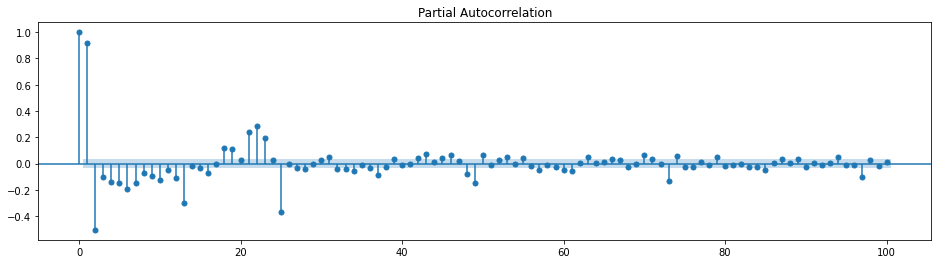

In [62]:
plot_pacf(df_test, lags=100)
plt.rcParams["figure.figsize"] = (16,4)
pyplot.show()

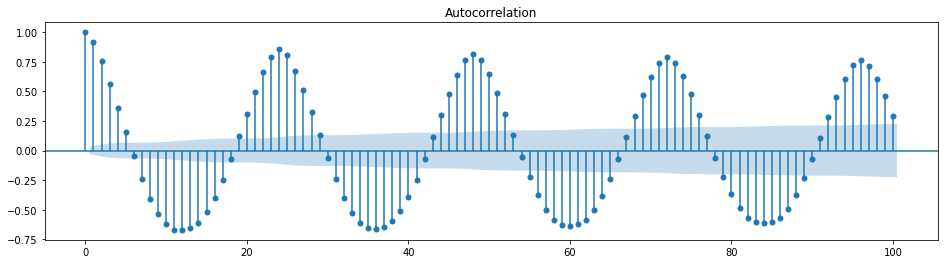

In [56]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_test, lags=100)
plt.rcParams["figure.figsize"] = (16,4)
pyplot.show()

As expected, we see the highest autocorrelation every 24h. However, the above plot simply looks at a time period of 5 days. If we increase it, as per below, we can clearly see a new pattern. This is the weekly pattern. Note how the initial pattern shows a damped behaviour, where the amplitude decays after each period. However, after 7 periods we see an increase, indicating that there is high correlation between those points separated by a week. This suggests that, for the future use of Seasonal ARIMA, we would ideally set the seasonal parameter as 24*7 = 168. i.e. the number of hours for each season (a week). Unfortunately, we do not have enough computer power to run SARIMA under this parameter, so we will have to either run ARIMA with an autoregressive parameter of 24 or SARIMA with a seasonal parameter of 24, keeping the autoregressive parameter as 1. We will compare the results obtained from both models. 

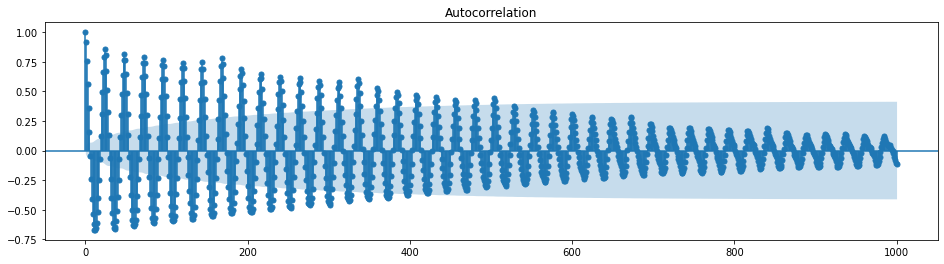

In [57]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_test, lags=1000)
plt.rcParams["figure.figsize"] = (16,4)
pyplot.show()

We perform a walk-forward validation

In [66]:
#takes about 15 mins to run
history = list(y_train)
predictions = list()
# walk-forward validation
predictions = []
for t in range(len(y_test)):
    model = ARIMA(history, order=(24,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=111.489407, expected=112.461538
predicted=120.338947, expected=121.454545
predicted=123.234383, expected=122.153846
predicted=118.085403, expected=118.727273
predicted=115.980221, expected=117.153846
predicted=111.357485, expected=107.181818
predicted=100.197964, expected=96.461538
predicted=88.613705, expected=98.272727
predicted=105.385128, expected=99.923077
predicted=84.467556, expected=110.272727
predicted=96.187897, expected=86.769231
predicted=67.851857, expected=77.363636
predicted=63.140938, expected=58.769231
predicted=38.055420, expected=38.727273
predicted=23.667869, expected=28.384615
predicted=25.994168, expected=17.818182
predicted=13.346159, expected=10.769231
predicted=11.878516, expected=12.454545
predicted=23.350975, expected=25.230769
predicted=49.479633, expected=42.818182
predicted=89.214919, expected=78.307692
predicted=95.389802, expected=112.363636
predicted=119.419577, expected=127.769231
predicted=128.827372, expected=119.272727
predicted=118.004637

In order to evaluate our model, we look into the Root Mean Square Error, which tells us how concentrated the data is around the line of best fit. We found that the minimum RMSE (11.05) was achieved for the parameters (24,1,1).

In [68]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.052


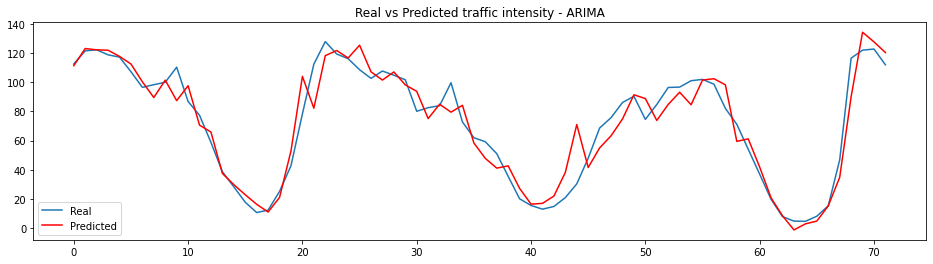

In [74]:
# plot forecasts against actual outcomes

plt.plot(y_test.values, label = 'Real')
plt.plot(predictions, color='red', label = 'Predicted')
plt.rcParams["figure.figsize"] = (16,4)
plt.legend(loc="lower left")
plt.title('Real vs Predicted traffic intensity - ARIMA')
plt.show()

# Seasonal ARIMA: SARIMAX

In [78]:
import statsmodels.api as sm

history = list(y_train)
predictions = list()
# walk-forward validation
predictions = []
for t in range(len(y_test)):
    model = sm.tsa.statespace.SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,24))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=111.288038, expected=112.461538
predicted=123.018932, expected=121.454545
predicted=122.136678, expected=122.153846
predicted=121.881150, expected=118.727273
predicted=117.658322, expected=117.153846
predicted=112.461220, expected=107.181818
predicted=100.265202, expected=96.461538
predicted=89.494589, expected=98.272727
predicted=101.403333, expected=99.923077
predicted=87.369986, expected=110.272727
predicted=97.561635, expected=86.769231
predicted=70.597995, expected=77.363636
predicted=65.851401, expected=58.769231
predicted=37.540356, expected=38.727273
predicted=29.862884, expected=28.384615
predicted=22.945578, expected=17.818182
predicted=16.408096, expected=10.769231
predicted=11.124505, expected=12.454545
predicted=21.115275, expected=25.230769
predicted=52.969153, expected=42.818182
predicted=103.993627, expected=78.307692
predicted=82.204640, expected=112.363636
predicted=118.151222, expected=127.769231
predicted=121.684417, expected=119.272727
predicted=116.53222

In [79]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.236


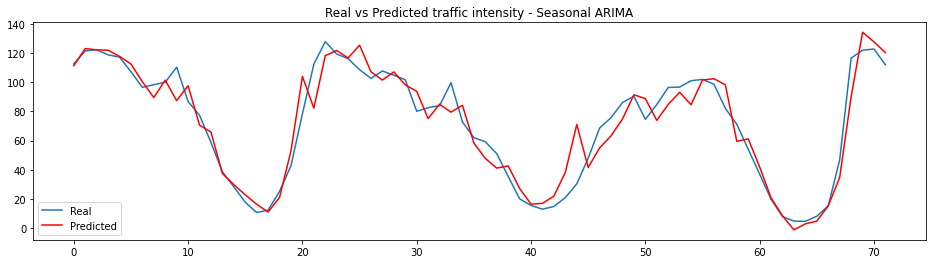

In [81]:
# plot forecasts against actual outcomes

plt.plot(y_test.values, label = 'Real')
plt.plot(predictions, color='red', label = 'Predicted')
plt.rcParams["figure.figsize"] = (16,4)
plt.legend(loc="lower left")
plt.title('Real vs Predicted traffic intensity - Seasonal ARIMA')
plt.show()

We see how using Seasonal ARIMA does not improve the model. As mentioned before, it would be ideal to test this model with the seasonal parameter = 168 instead of 24. However, due to computational limitations, this is not possible. 

In general, we see how we can get good traffic intensity predictions using the ARIMA and SARIMA models. However, this is limited to predicting 1h in the future each time. Therefore, we also want to check for larger time steps

#  RandomForestRegressor

For the RandomForestRegressor we take the meassurement from all sensors and the respective daytime. The first pre-processing step consists out of adding 4 addiditonal time features (during day, during day before lunch, during day and lunch, during day after lunch) and encoding the categorical variables.

In [26]:
df_RF=CT4Z7_by_h_cut_may2019.iloc[:,:23]

### delete this 3 rows ..
c_2_del =['dateobserved_year_x','dateobserved_month_x', 'dateobserved_day', 'dateobserved_hour']
for c in c_2_del:
    del df_RF[c]
    
df_RF["dateobserved"]=pd.to_datetime(pd.Series(
    df_RF["dateobserved"]),format="%Y-%m-%d %H:%M:%S")
df_RF["dateobservedfrom_hour"]=df_RF.dateobserved.dt.hour
df_RF["dateobservedfrom_year"]=df_RF.dateobserved.dt.year
df_RF["dateobservedfrom_month"]=df_RF.dateobserved.dt.month
df_RF["dateobservedfrom_day"]=df_RF.dateobserved.dt.day
df_RF["dateobservedfrom_dayofweek"]=df_RF.dateobserved.dt.dayofweek    
    
    
    
    
# add additional time features
# during the day before lunch
df_RF["day_before_lunch"]=df_RF.dateobservedfrom_hour.apply(lambda x: True if (x>=6)*(x<12) else False) 
# during the day + during lunch
df_RF["day_during_lunch"]=df_RF.dateobservedfrom_hour.apply(lambda x: True if (x>=12)*(x<14) else False) 
# during the day + after lunch
df_RF["day_after_lunch"]=df_RF.dateobservedfrom_hour.apply(lambda x: True if (x>=14)*(x<22) else False) 
# during the day + after lunch
df_RF["day"]=df_RF.dateobservedfrom_hour.apply(lambda x: True if (x>=6)*(x<22) else False)

# encode
def dummy_encode(df,arr_cols):
    for c in arr_cols:
        if "dateobservedfrom_" in c:
            df = pd.get_dummies(df, columns=[c], drop_first=False, prefix=c.replace("dateobservedfrom_",""))
        else:
            df = pd.get_dummies(df, columns=[c], drop_first=False, prefix=c)
    return df
df_RF.columns

df_RF_encoded = dummy_encode(df_RF,["dateobservedfrom_year","dateobservedfrom_month","dateobservedfrom_hour",
                                   "dateobservedfrom_dayofweek","day",
                                    "day_before_lunch","day_after_lunch","day_during_lunch"])
ft_names = df_RF_encoded.columns.to_list()
ft_names.remove("intensity")

We have two different ways to create the forest model: 1) Stepwise as in the previous parts to compare it better to ARIMA 2) train on a certain percentage of data and predict the other part


Method 1: Stepwise: Create the Model (according to parameters from a grid-search). Test the model stepwise by performing the following taks: Seperate data in traininng and test data, impute the data, train the model and calculate error

In [30]:
model_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
            min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

X=df_RF_encoded.iloc[:,2:]
y=df_RF_encoded.iloc[:,1:2]

train_size = int(len(df_RF_encoded) * 0.925)
print("Train size has length",len(df_RF_encoded[:train_size]),
      "and test size ",len(df_RF_encoded[train_size:]))


# stepwise testing    don´t run this cell if not necessary ... too much computation time needed 
truely_needed =False
counter =0
predictions_setpwise =[]

# supress watnings
import sys,warnings,os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
for i in range(train_size, len(df_RF_encoded)):  
    if truely_needed==False: break
    counter +=1
    if counter%10==0:
        print("counter",counter)
    # split data 
    X_train, X_test = X.iloc[:i], X.iloc[i:i+1]
    y_train, y_test = y.iloc[:i], y.iloc[i:i+1]
    
    # impute with the mean based on what has been alread seen 
    imp = IterativeImputer(max_iter=10, random_state=0)
    imp.fit(X_train)
    IterativeImputer(random_state=0)
    X_train=imp.transform(X_train)
    X_test=imp.transform(X_test)
    
    model_rf.fit(X_train, y_train) 
    pred_test_rf = model_rf.predict(X_test)
    predictions_setpwise.append(pred_test_rf[0]) 
    
    ## give status overview
    status = np.round(100*(i-train_size)/(len(X)-train_size),2)
    if status%5==0:
        print('train=%d, percentage=%d/100' % (len(y_train),status))
   
y_test=y.iloc[int(len(df_RF_encoded) * 0.925):]
predictions_setpwise
print("r2_score on test",r2_score(y_test, predictions_setpwise))
rms = mean_squared_error(y_test, predictions_setpwise, squared=False)
print("rms test",rms)

## 17 min for 30

Train size has length 3792 and test size  308
train=3792, percentage=0/100
counter 10
counter 20
counter 30
counter 40
counter 50
counter 60
counter 70
train=3869, percentage=25/100
counter 80
counter 90
counter 100
counter 110
counter 120
counter 130
counter 140
counter 150
train=3946, percentage=50/100
counter 160
counter 170
counter 180
counter 190
counter 200
counter 210
counter 220
counter 230
train=4023, percentage=75/100
counter 240
counter 250
counter 260
counter 270
counter 280
counter 290
counter 300
r2_score on test 0.9726829756641295
rms test 6.9162688211631425



The model performs extremly well but with the input we can not come to  a clear conclusion. It might be that we are predicting something that we fed as input, that for example an underlying factor of the traffic intensity also affects the other sensor data or that the traffic level influenced heavily the other sensor data. 

Method 2:

r2_score on train 3.52194880843195
0.9929947967495376
10.466238428072154
r2_score on test 0.9343236659593281
rms test 10.466238428072154


<IPython.core.display.Javascript object>


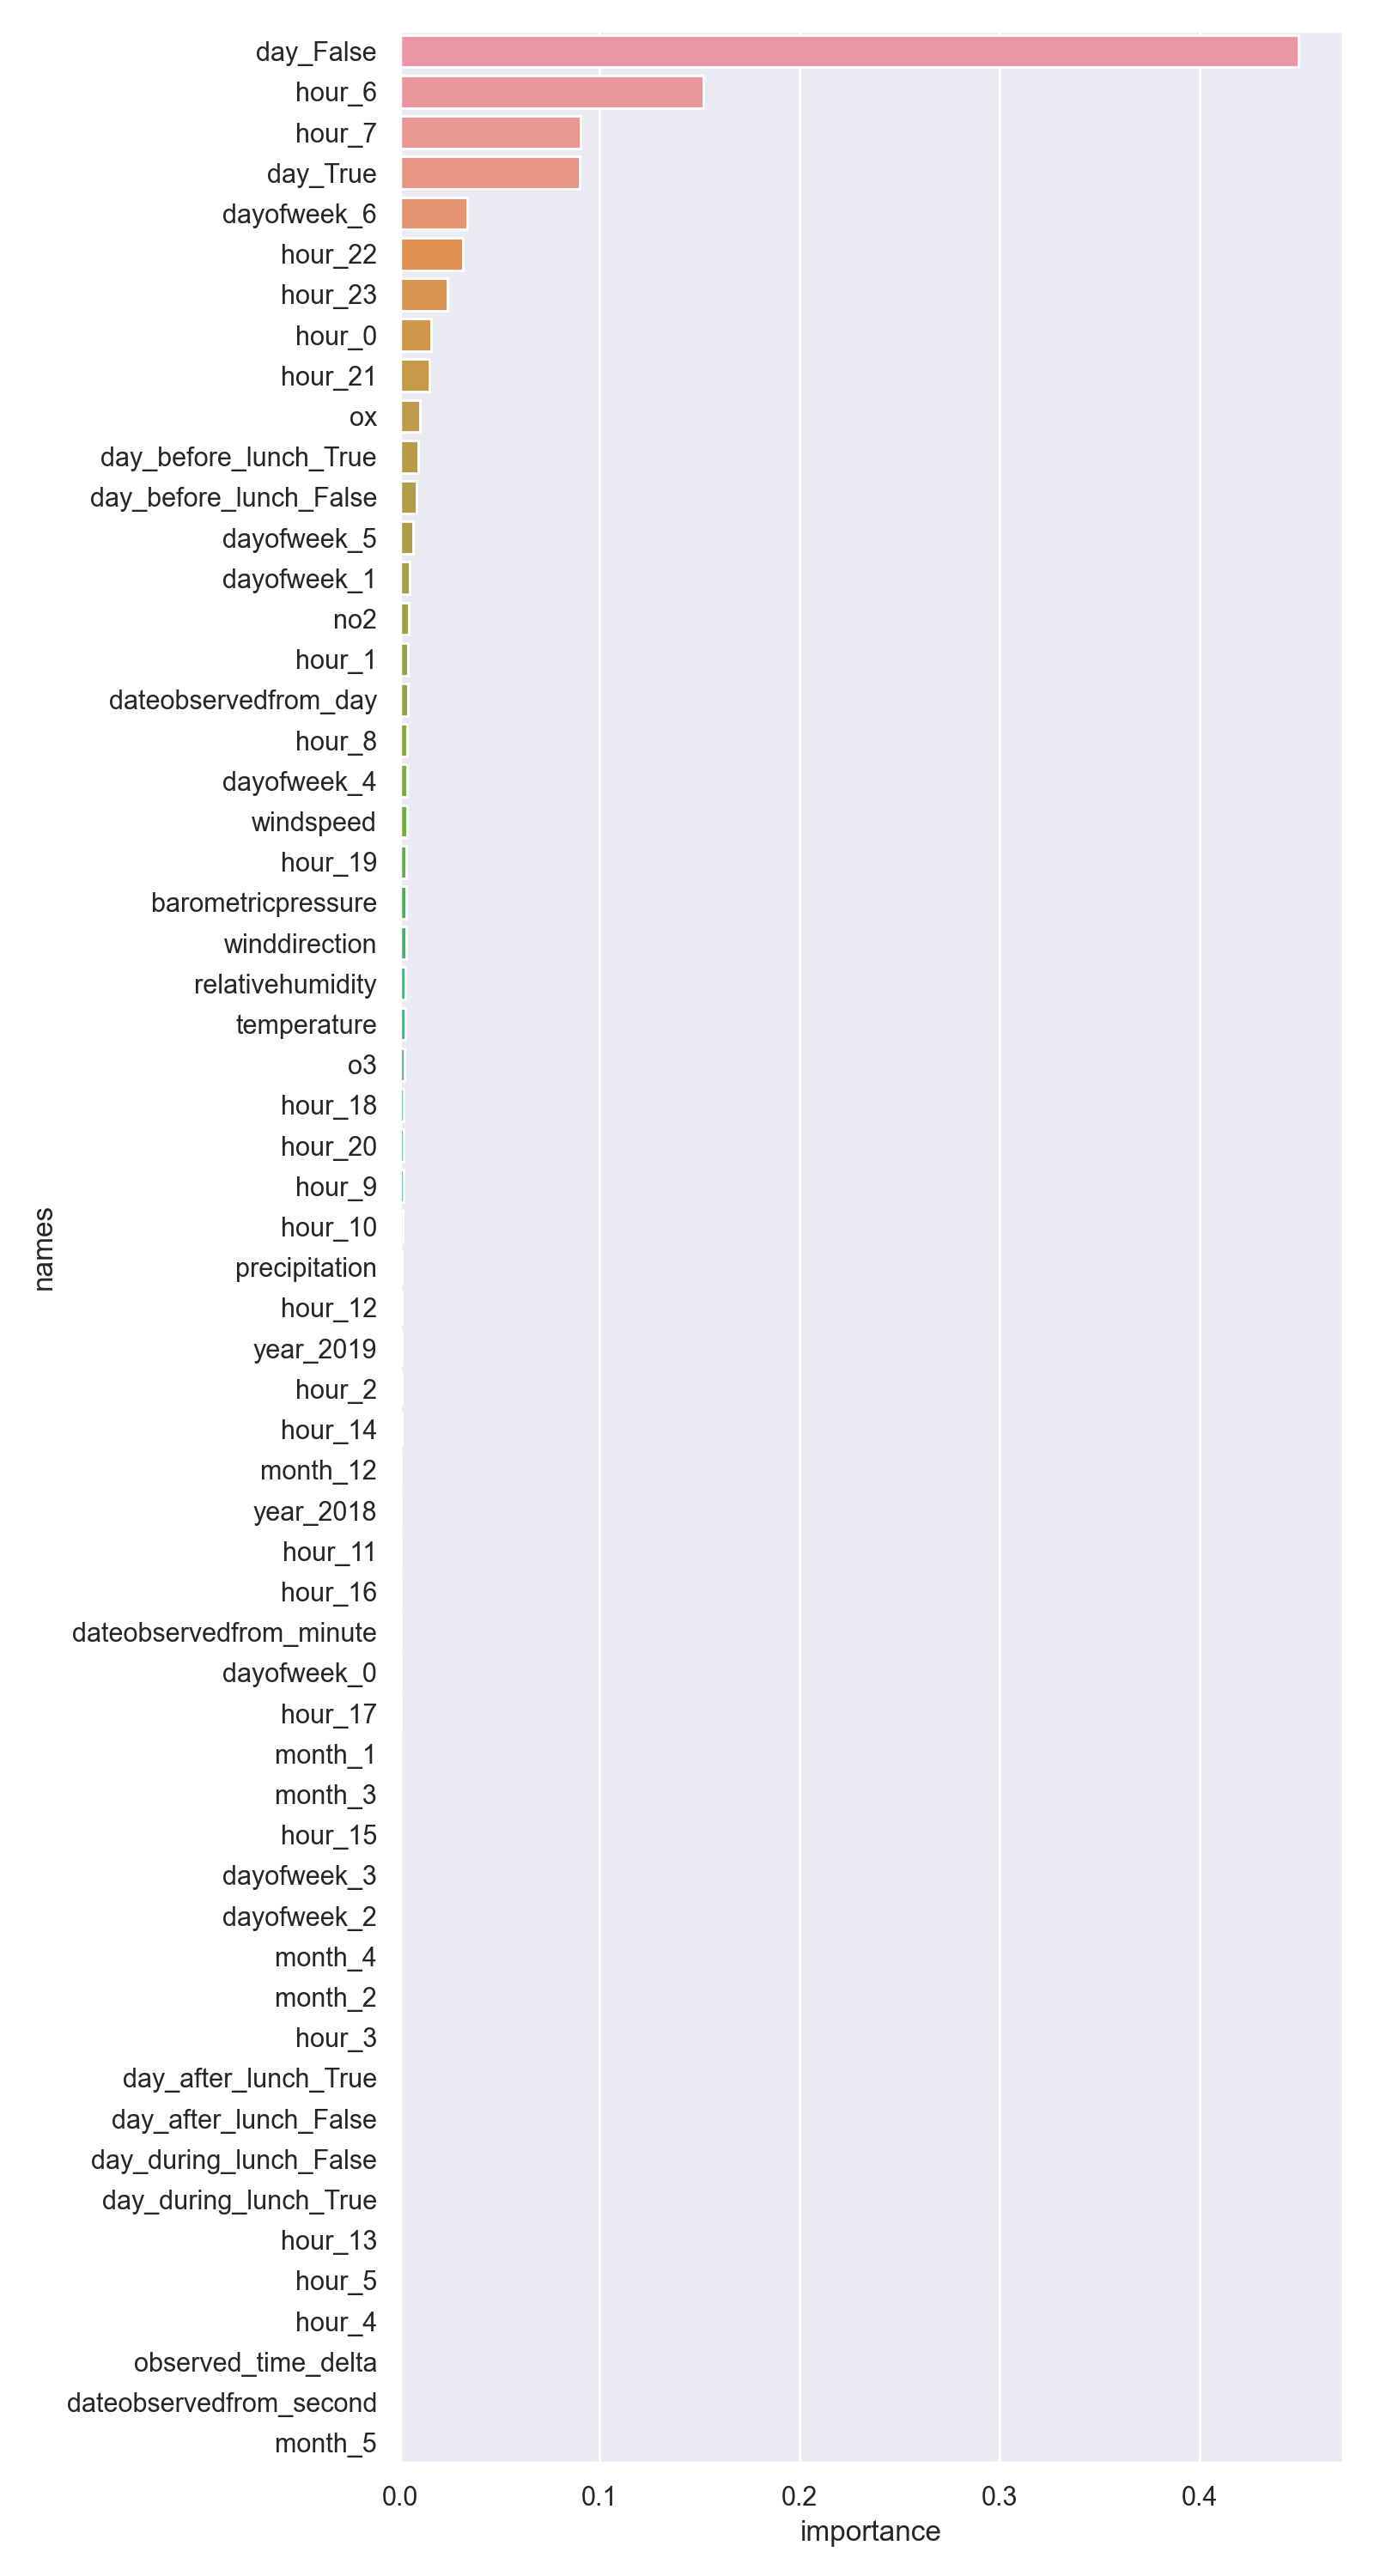

In [28]:
model_rf2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
            min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

train_size = int(len(df_RF_encoded) * 0.7)
 # split data 
X_train2, X_test2 = X.iloc[:train_size], X.iloc[train_size:]
y_train2, y_test2 = y.iloc[:train_size], y.iloc[train_size:]

# impute with the mean based on what has been alread seen 
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train2)
IterativeImputer(random_state=0)
X_train2=imp.transform(X_train2)
X_test2=imp.transform(X_test2)

model_rf2.fit(X_train2, y_train2) 
pred_train_rf2= model_rf2.predict(X_train2)


print("r2_score on train",np.sqrt(mean_squared_error(y_train2,pred_train_rf2)))
print(r2_score(y_train2, pred_train_rf2))

pred_test_rf2 = model_rf2.predict(X_test2)
print(np.sqrt(mean_squared_error(y_test2,pred_test_rf2)))
print("r2_score on test",r2_score(y_test2, pred_test_rf2))
rms2 = mean_squared_error(y_test2, pred_test_rf2, squared=False)
print("rms test",rms2)

feature_imp = pd.DataFrame({"names":X.columns,"importance":model_rf2.feature_importances_}).sort_values(
    by =["importance"],ascending=False)

f, ax = plt.subplots(figsize=(8, 15))
plot=sns.barplot(y="names", x="importance", data=feature_imp)
plt.tight_layout()



We see that the most important features are related to time and not to sensor data.

# Relationship analysis

In [ ]:
#Datasets straigh from Yago's preprocessing !!! Check !!!
traffic_2019 = traffic_df_2019
data_ent     = data_ent

## Sensors we look at

In [ ]:
#show the location of the sensors
center_city = (41.157227, -8.624872)
m = Map(center=center_city, zoom=13)

for index, row in data_ent[data_ent['entity_type']=='TrafficFlowObserved'].iterrows():
    if (index in [73,64,82,55,82,92,41,178,   85,95,76,58,44]):
        loc = (float(row['latitude']), float(row['longitude']))
        m.add_layer(Marker(location=loc, draggable=False, icon=AwesomeIcon(name='car', marker_color='red')))
display(m)

## Prepare the data

In [ ]:
# Get ids of the desired sensors
ids_long_road = []
for index, row in data_ent.iterrows():
    if index in [73,64,82]:
        ids_long_road.append(row['entity_id'])
        
ids_roundabout = []
for index, row in data_ent.iterrows():
    if index in [85,95,44]:
        ids_roundabout.append(row['entity_id'])

Get 2019 traffic data for our sensors

In [ ]:
traffic_2019["dateobservedfrom"] = pd.to_datetime(pd.Series(traffic_2019["dateobservedfrom"]),format="%Y-%m-%d %H:%M:%S")
traffic_2019.sort_values(by=['dateobservedfrom'], inplace=True)

In [ ]:
#Long Road
lr1 = traffic_2019[traffic_2019['entity_id'] == ids_long_road[0]]
lr2 = traffic_2019[traffic_2019['entity_id'] == ids_long_road[1]]
lr3 = traffic_2019[traffic_2019['entity_id'] == ids_long_road[2]]

#Roundabout
rb1 = traffic_2019[traffic_2019['entity_id'] == ids_roundabout[0]]
rb2 = traffic_2019[traffic_2019['entity_id'] == ids_roundabout[1]]
rb3 = traffic_2019[traffic_2019['entity_id'] == ids_roundabout[2]]

#Set indexes for plotting
for dataset in [lr1,lr2,lr3, rb1,rb2,rb3]:
    dataset.set_index('dateobservedfrom', inplace=True)

## Visualise the data

First we need to smoothen the curves to more clearly see trends

In [ ]:
#By how much soothened:
sooth = '30min'

#Sample to see:
start = pd.Timestamp('2019-08-09 00:00:00')
stop  = pd.Timestamp('2019-08-10 00:00:00')

smoothed_lr1 = lr1[['intensity']][start:stop].resample(sooth).median()
smoothed_lr2 = lr2[['intensity']][start:stop].resample(sooth).median()
smoothed_lr3 = lr3[['intensity']][start:stop].resample(sooth).median()

smoothed_rb1 = rb1[['intensity']][start:stop].resample(sooth).median()
smoothed_rb2 = rb2[['intensity']][start:stop].resample(sooth).median()
smoothed_rb3 = rb3[['intensity']][start:stop].resample(sooth).median()

### Roundabout

In [ ]:
m1 = Map(center=center_city, zoom=14)
for index, row in data_ent[data_ent['entity_type']=='TrafficFlowObserved'].iterrows():
    if (index in [85,95,44]):
        loc = (float(row['latitude']), float(row['longitude']))
        m1.add_layer(Marker(location=loc, draggable=False, icon=AwesomeIcon(name='car', marker_color='red')))
display(m1)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(smoothed_rb1,label='right node', color='red')
ax.plot(smoothed_rb3,label='middle node', color='green')
ax.plot(smoothed_rb2,label='left node', color='blue')

ax.legend()
plt.show()

Looking at several soothing levels we can see that the 'left node' is a good predictor of what will happen in the next 10-15min in the 'right node'. This relationship holds up to around 1pm, after which the 'righ node' is a good predictor of what will happen in the 'left node'. This is expected, since in the mornings we tipically observe inflows to the city and aoutflows in the eveing. An extension of this model would be to use more sensors on road, and adapt the behaviour on one end of the road depending on what is happening on the other end

### Long road

In [ ]:
m2 = Map(center=(41.165175, -8.672251), zoom=15)
for index, row in data_ent[data_ent['entity_type']=='TrafficFlowObserved'].iterrows():
    if (index in [73,64,82]):
        loc = (float(row['latitude']), float(row['longitude']))
        m2.add_layer(Marker(location=loc, draggable=False, icon=AwesomeIcon(name='car', marker_color='red')))
display(m2)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(smoothed_lr1,label='middle node', color='red')
ax.plot(smoothed_lr2,label='left node', color='blue')
ax.plot(smoothed_lr3,label='right node', color='green')

ax.legend()
plt.show()

### Inner city vs outer city - same road

In [ ]:
m3 = Map(center=center_city, zoom=13)
for index, row in data_ent[data_ent['entity_type']=='TrafficFlowObserved'].iterrows():
    if (index in [64, 85,44,]):
        loc = (float(row['latitude']), float(row['longitude']))
        m3.add_layer(Marker(location=loc, draggable=False, icon=AwesomeIcon(name='car', marker_color='red')))
display(m3)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(smoothed_lr1,label='left node', color='red')
ax.plot(smoothed_rb2,label='middle node', color='blue')
ax.plot(smoothed_rb1,label='right node', color='green')

ax.legend()
plt.show()

From the graph above we can see that there is a difference in conjestion depending on the distance to the city centre. Part of the road closer to the city centre gets highly conjested faster (as early as 7pm), while part far away to the city centre get conjested a few hours later.